## Weather EDA
### University of Virginia
### DS 5110: Big Data Systems
### By: TeamBike

**Create the SparkSession instance with appName 'weather'.**

In [2]:
# need to import SparkSession
# make .appName 'weather'

from pyspark.sql import SparkSession

spark = SparkSession.builder \
        .appName("weather") \
        .getOrCreate()

In [3]:
%matplotlib inline

**Read in the dataset**

In [4]:
# note that read.json can read a zipped JSON directly
df = spark.read.parquet("/project/ds5559/Summer2021_TeamBike/weatherRainSnowClouds.parquet");
print(type(df)) # I want to see what type of object this created to make sure it's a DF

<class 'pyspark.sql.dataframe.DataFrame'>


**Data has been read in and set to variable *df* as a data frame. Record count is:**

In [5]:
print('There are %1d records in the data.' % (df.count())) # show the number of records:

There are 79287 records in the data.


**Print the schema**

**Can print the schema using *.printSchema()*. Schema is:**

In [6]:
df.printSchema()

root
 |-- dt: long (nullable = true)
 |-- dt_iso: string (nullable = true)
 |-- temp: double (nullable = true)
 |-- feels_like: double (nullable = true)
 |-- temp_min: double (nullable = true)
 |-- temp_max: double (nullable = true)
 |-- pressure: long (nullable = true)
 |-- humidity: long (nullable = true)
 |-- wind_speed: double (nullable = true)
 |-- rain_1h: double (nullable = true)
 |-- rain_3h: double (nullable = true)
 |-- snow_1h: double (nullable = true)
 |-- snow_3h: double (nullable = true)
 |-- clouds_all: long (nullable = true)
 |-- weather_id: long (nullable = true)
 |-- weather_main: string (nullable = true)



**Showing the first 5 records using *show()*:**

In [7]:
df.show(5) # show top-5 rows using .show()

+----------+--------------------+------+----------+--------+--------+--------+--------+----------+-------+-------+-------+-------+----------+----------+------------+
|        dt|              dt_iso|  temp|feels_like|temp_min|temp_max|pressure|humidity|wind_speed|rain_1h|rain_3h|snow_1h|snow_3h|clouds_all|weather_id|weather_main|
+----------+--------------------+------+----------+--------+--------+--------+--------+----------+-------+-------+-------+-------+----------+----------+------------+
|1457467200|2016-03-08 20:00:...|288.17|    283.38| 282.685|  290.35|    1020|      37|       4.1|    NaN|    NaN|    NaN|    NaN|         1|       800|       Clear|
|1457470800|2016-03-08 21:00:...|286.82|    283.72| 282.205|  289.25|    1020|      46|       2.1|    NaN|    NaN|    NaN|    NaN|         1|       800|       Clear|
|1457474400|2016-03-08 22:00:...|285.94|    283.32| 281.925|  287.55|    1020|      50|       1.5|    NaN|    NaN|    NaN|    NaN|         1|       721|        Haze|
|145

**Notice NaN values in some fields. Replace with 0 here since they represent no precipitation.**

In [8]:
df = df.na.fill(value=0,subset=['rain_1h', 'rain_3h', 'snow_1h', 'snow_3h'])

### Feature Engineering

In [9]:
from pyspark.sql.functions import round, col, dayofweek, split, create_map, lit, udf
from itertools import chain
from pyspark.sql.types import StringType, IntegerType

**Clean up the date field.**

In [10]:
df = df.withColumn('date', split(df['dt_iso'], ' ').getItem(0)) \
       .withColumn('time', split(df['dt_iso'], ' ').getItem(1)) \
#df.show(truncate=False)

In [11]:
df.show(truncate=False)

+----------+-----------------------------+------+----------+--------+--------+--------+--------+----------+-------+-------+-------+-------+----------+----------+------------+----------+--------+
|dt        |dt_iso                       |temp  |feels_like|temp_min|temp_max|pressure|humidity|wind_speed|rain_1h|rain_3h|snow_1h|snow_3h|clouds_all|weather_id|weather_main|date      |time    |
+----------+-----------------------------+------+----------+--------+--------+--------+--------+----------+-------+-------+-------+-------+----------+----------+------------+----------+--------+
|1457467200|2016-03-08 20:00:00 +0000 UTC|288.17|283.38    |282.685 |290.35  |1020    |37      |4.1       |0.0    |0.0    |0.0    |0.0    |1         |800       |Clear       |2016-03-08|20:00:00|
|1457470800|2016-03-08 21:00:00 +0000 UTC|286.82|283.72    |282.205 |289.25  |1020    |46      |2.1       |0.0    |0.0    |0.0    |0.0    |1         |800       |Clear       |2016-03-08|21:00:00|
|1457474400|2016-03-08 22

In [12]:
# no longer need the full date field
df = df.drop('dt_iso', 'dt_iso', 'dt')\
.withColumn('temp_min',round('temp_min',3))\
.withColumn('temp_max',round('temp_min',3))\

In [13]:
df.show(truncate=False)

+------+----------+--------+--------+--------+--------+----------+-------+-------+-------+-------+----------+----------+------------+----------+--------+
|temp  |feels_like|temp_min|temp_max|pressure|humidity|wind_speed|rain_1h|rain_3h|snow_1h|snow_3h|clouds_all|weather_id|weather_main|date      |time    |
+------+----------+--------+--------+--------+--------+----------+-------+-------+-------+-------+----------+----------+------------+----------+--------+
|288.17|283.38    |282.685 |282.685 |1020    |37      |4.1       |0.0    |0.0    |0.0    |0.0    |1         |800       |Clear       |2016-03-08|20:00:00|
|286.82|283.72    |282.205 |282.205 |1020    |46      |2.1       |0.0    |0.0    |0.0    |0.0    |1         |800       |Clear       |2016-03-08|21:00:00|
|285.94|283.32    |281.925 |281.925 |1020    |50      |1.5       |0.0    |0.0    |0.0    |0.0    |1         |721       |Haze        |2016-03-08|22:00:00|
|284.89|282.38    |281.851 |281.851 |1020    |56      |1.5       |0.0    |0.

#### Create Day and Month Dictionaries to map variables

In [17]:
days = ['Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday'];
dow = {i + 1:days[i] for i in range(7)};
mos = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'];
mos_d = {i + 1:mos[i] for i in range(12)};

In [18]:
dow

{1: 'Sunday',
 2: 'Monday',
 3: 'Tuesday',
 4: 'Wednesday',
 5: 'Thursday',
 6: 'Friday',
 7: 'Saturday'}

In [19]:
mos_d

{1: 'Jan',
 2: 'Feb',
 3: 'Mar',
 4: 'Apr',
 5: 'May',
 6: 'Jun',
 7: 'Jul',
 8: 'Aug',
 9: 'Sep',
 10: 'Oct',
 11: 'Nov',
 12: 'Dec'}

In [21]:
# return the day of the week for each date
df = df.withColumn('dow', dayofweek('date'));
df.show(truncate=False)

+------+----------+--------+--------+--------+--------+----------+-------+-------+-------+-------+----------+----------+------------+----------+--------+---+
|temp  |feels_like|temp_min|temp_max|pressure|humidity|wind_speed|rain_1h|rain_3h|snow_1h|snow_3h|clouds_all|weather_id|weather_main|date      |time    |dow|
+------+----------+--------+--------+--------+--------+----------+-------+-------+-------+-------+----------+----------+------------+----------+--------+---+
|288.17|283.38    |282.685 |282.685 |1020    |37      |4.1       |0.0    |0.0    |0.0    |0.0    |1         |800       |Clear       |2016-03-08|20:00:00|3  |
|286.82|283.72    |282.205 |282.205 |1020    |46      |2.1       |0.0    |0.0    |0.0    |0.0    |1         |800       |Clear       |2016-03-08|21:00:00|3  |
|285.94|283.32    |281.925 |281.925 |1020    |50      |1.5       |0.0    |0.0    |0.0    |0.0    |1         |721       |Haze        |2016-03-08|22:00:00|3  |
|284.89|282.38    |281.851 |281.851 |1020    |56    

**Create mapping function:**

In [23]:
def translate(mapping):
    def translate_(col):
        return mapping.get(col)
    return udf(translate_, StringType())

df = df.withColumn('day', translate(dow)('dow')) # map from dow to actual day name (Monday, Tuesday, etc.)

In [25]:
df.show()

+------+----------+--------+--------+--------+--------+----------+-------+-------+-------+-------+----------+----------+------------+----------+--------+---+---------+
|  temp|feels_like|temp_min|temp_max|pressure|humidity|wind_speed|rain_1h|rain_3h|snow_1h|snow_3h|clouds_all|weather_id|weather_main|      date|    time|dow|      day|
+------+----------+--------+--------+--------+--------+----------+-------+-------+-------+-------+----------+----------+------------+----------+--------+---+---------+
|288.17|    283.38| 282.685| 282.685|    1020|      37|       4.1|    0.0|    0.0|    0.0|    0.0|         1|       800|       Clear|2016-03-08|20:00:00|  3|  Tuesday|
|286.82|    283.72| 282.205| 282.205|    1020|      46|       2.1|    0.0|    0.0|    0.0|    0.0|         1|       800|       Clear|2016-03-08|21:00:00|  3|  Tuesday|
|285.94|    283.32| 281.925| 281.925|    1020|      50|       1.5|    0.0|    0.0|    0.0|    0.0|         1|       721|        Haze|2016-03-08|22:00:00|  3|  T

**Isolate hour, month, etc.**

In [29]:
df = df.withColumn('month', split(df['date'], '-').getItem(1))\
.withColumn('hour', split(df['time'], ':').getItem(0)) \


**Map from month number to month name:**

In [30]:
df = df.withColumn('month', df['month'].cast(IntegerType()))\
.withColumn('month', translate(mos_d)('month'))\
.withColumn('hour', df['hour'].cast(IntegerType()))

In [32]:
df.show()

+------+----------+--------+--------+--------+--------+----------+-------+-------+-------+-------+----------+----------+------------+----------+--------+---+---------+-----+----+
|  temp|feels_like|temp_min|temp_max|pressure|humidity|wind_speed|rain_1h|rain_3h|snow_1h|snow_3h|clouds_all|weather_id|weather_main|      date|    time|dow|      day|month|hour|
+------+----------+--------+--------+--------+--------+----------+-------+-------+-------+-------+----------+----------+------------+----------+--------+---+---------+-----+----+
|288.17|    283.38| 282.685| 282.685|    1020|      37|       4.1|    0.0|    0.0|    0.0|    0.0|         1|       800|       Clear|2016-03-08|20:00:00|  3|  Tuesday|  Mar|  20|
|286.82|    283.72| 282.205| 282.205|    1020|      46|       2.1|    0.0|    0.0|    0.0|    0.0|         1|       800|       Clear|2016-03-08|21:00:00|  3|  Tuesday|  Mar|  21|
|285.94|    283.32| 281.925| 281.925|    1020|      50|       1.5|    0.0|    0.0|    0.0|    0.0|       

*Hour Mapping*

In [33]:
from pyspark.sql.functions import when

df = df.withColumn('time_bin', when(col('hour') < 5, 'Night')
.when(col('hour') < 12, 'Morning')
.when(col('hour') < 17, 'Afternoon')
.when(col('hour') <= 21, 'Evening')
.otherwise('Night'))

**Create peak commute variables:**

In [34]:
# commuting peak

df = df.withColumn('peak_commute', when(((col('hour').between(7, 10)) | (col('hour').between(16, 19))) & (col('dow').between(2, 6)), 'peak')
.otherwise('non_peak'))

In [35]:
df.where(df.day == 'Sunday').show()

+------+----------+--------+--------+--------+--------+----------+-------+-------+-------+-------+----------+----------+------------+----------+--------+---+------+-----+----+---------+------------+
|  temp|feels_like|temp_min|temp_max|pressure|humidity|wind_speed|rain_1h|rain_3h|snow_1h|snow_3h|clouds_all|weather_id|weather_main|      date|    time|dow|   day|month|hour| time_bin|peak_commute|
+------+----------+--------+--------+--------+--------+----------+-------+-------+-------+-------+----------+----------+------------+----------+--------+---+------+-----+----+---------+------------+
|285.77|    281.16|  283.15|  283.15|    1018|      47|       4.1|    0.0|    0.0|    0.0|    0.0|         1|       800|       Clear|2016-03-13|00:00:00|  1|Sunday|  Mar|   0|    Night|    non_peak|
|285.93|    282.89| 283.944| 283.944|    1018|      50|       2.1|    0.0|    0.0|    0.0|    0.0|         1|       800|       Clear|2016-03-13|01:00:00|  1|Sunday|  Mar|   1|    Night|    non_peak|
|285.

**Weather variables are in Kelvin. Need to convert to Fahrenheit.**

In [36]:
df = df.withColumn('temp', (df.temp - 273.15) * 9/5 + 32)\
.withColumn('feels_like', (df.feels_like - 273.15) * 9/5 + 32)\
.withColumn('temp_min', (df.temp_min - 273.15) * 9/5 + 32)\
.withColumn('temp_max', (df.temp_max - 273.15) * 9/5 + 32)\
.withColumn('temp', round('temp', 3))\
.withColumn('feels_like', round('feels_like', 3))\
.withColumn('temp_min', round('temp_min', 3))\
.withColumn('temp_max', round('temp_max', 3))\
.drop('time')\
.drop('weather_id')

In [37]:
df.where(df.day == 'Sunday').show()

+------+----------+--------+--------+--------+--------+----------+-------+-------+-------+-------+----------+------------+----------+---+------+-----+----+---------+------------+
|  temp|feels_like|temp_min|temp_max|pressure|humidity|wind_speed|rain_1h|rain_3h|snow_1h|snow_3h|clouds_all|weather_main|      date|dow|   day|month|hour| time_bin|peak_commute|
+------+----------+--------+--------+--------+--------+----------+-------+-------+-------+-------+----------+------------+----------+---+------+-----+----+---------+------------+
|54.716|    46.418|    50.0|    50.0|    1018|      47|       4.1|    0.0|    0.0|    0.0|    0.0|         1|       Clear|2016-03-13|  1|Sunday|  Mar|   0|    Night|    non_peak|
|55.004|    49.532|  51.429|  51.429|    1018|      50|       2.1|    0.0|    0.0|    0.0|    0.0|         1|       Clear|2016-03-13|  1|Sunday|  Mar|   1|    Night|    non_peak|
|54.968|    48.236|  51.271|  51.271|    1017|      50|       3.1|    0.0|    0.0|    0.0|    0.0|       

### Combine Weather data with Citi Bike data:

In [41]:
import os

In [42]:
os.getcwd()

'/sfs/qumulo/qhome/dmf4ns/ds5110/dmf/project'

In [43]:
#os.chdir('/project/ds5559/Summer2021_TeamBike/')

In [44]:
#os.getcwd()

In [45]:
import glob
# All files ending with .txt
files = glob.glob("/project/ds5559/Summer2021_TeamBike/CitiBikeAllYears*.parquet/")

In [34]:
files_set = set(files)

In [35]:
len(files_set)

5

In [37]:
#bike_test = spark.read.parquet(files[0], files[1], files[2], files[3])

bike0 = spark.read.parquet('/project/ds5559/Summer2021_TeamBike/CitiBikeAllYears2013-2018.parquet/');
bike1 = spark.read.parquet('/project/ds5559/Summer2021_TeamBike/CitiBikeAllYears202001-202012.parquet/');
bike2 = spark.read.parquet('/project/ds5559/Summer2021_TeamBike/CitiBikeAllYears201305-201812.parquet/');
bike3 = spark.read.parquet('/project/ds5559/Summer2021_TeamBike/CitiBikeAllYears201901-201912.parquet/');
bike4 = spark.read.parquet('/project/ds5559/Summer2021_TeamBike/CitiBikeAllYears202101-202105.parquet/')

In [38]:
bike = bike0.union(bike1)\
.union(bike2)\
.union(bike3)\
.union(bike4)

**Show bike data**

In [39]:
bike.show()

+------------+--------------------+--------------+------------------+--------------------+---------------------+------------+--------------------+------------------+-------------------+-------+----------+---------+------+
|tripduration|           starttime|startStationId|  startStationName|startStationLatitude|startStationLongitude|endStationId|      endStationName|endStationLatitude|endStationLongitude| bikeid|  usertype|birthyear|gender|
+------------+--------------------+--------------+------------------+--------------------+---------------------+------------+--------------------+------------------+-------------------+-------+----------+---------+------+
|         598|2018-06-20 17:44:...|          3236|W 42 St & Dyer Ave|   40.75898361206055|    -73.9937973022461|       442.0|     W 27 St & 7 Ave|40.746646881103516| -73.99391174316406|32018.0|Subscriber|     1971|   1.0|
|         674|2018-06-20 17:52:...|          3236|W 42 St & Dyer Ave|   40.75898361206055|    -73.9937973022461|

In [40]:
bike.count()

182901681

In [41]:
bike = bike.withColumn('date', split(bike['starttime'], ' ').getItem(0))\
.withColumn('hour', split(bike['starttime'], ' ').getItem(1))

In [42]:
from pyspark.sql.functions import to_date, date_format

bike = bike.withColumn('date', date_format(col('date'), "yyyy-MM-dd"))

In [43]:
bike.show()

+------------+--------------------+--------------+------------------+--------------------+---------------------+------------+--------------------+------------------+-------------------+-------+----------+---------+------+----------+-------------+
|tripduration|           starttime|startStationId|  startStationName|startStationLatitude|startStationLongitude|endStationId|      endStationName|endStationLatitude|endStationLongitude| bikeid|  usertype|birthyear|gender|      date|         hour|
+------------+--------------------+--------------+------------------+--------------------+---------------------+------------+--------------------+------------------+-------------------+-------+----------+---------+------+----------+-------------+
|         598|2018-06-20 17:44:...|          3236|W 42 St & Dyer Ave|   40.75898361206055|    -73.9937973022461|       442.0|     W 27 St & 7 Ave|40.746646881103516| -73.99391174316406|32018.0|Subscriber|     1971|   1.0|2018-06-20|17:44:04.1740|
|         67

In [46]:
bike.show()

+------------+--------------------+--------------+------------------+--------------------+---------------------+------------+--------------------+------------------+-------------------+-------+----------+---------+------+----------+-------------+
|tripduration|           starttime|startStationId|  startStationName|startStationLatitude|startStationLongitude|endStationId|      endStationName|endStationLatitude|endStationLongitude| bikeid|  usertype|birthyear|gender|      date|         hour|
+------------+--------------------+--------------+------------------+--------------------+---------------------+------------+--------------------+------------------+-------------------+-------+----------+---------+------+----------+-------------+
|         598|2018-06-20 17:44:...|          3236|W 42 St & Dyer Ave|   40.75898361206055|    -73.9937973022461|       442.0|     W 27 St & 7 Ave|40.746646881103516| -73.99391174316406|32018.0|Subscriber|     1971|   1.0|2018-06-20|17:44:04.1740|
|         67

**Split Bike date and time out into columns for joining to Weather data:**

In [47]:
bike = bike.withColumn('hour', split(bike['hour'], ':').getItem(0))

In [48]:
bike = bike.withColumn('hour', bike['hour'].cast(IntegerType()))

In [49]:
bike.show()

+------------+--------------------+--------------+------------------+--------------------+---------------------+------------+--------------------+------------------+-------------------+-------+----------+---------+------+----------+----+
|tripduration|           starttime|startStationId|  startStationName|startStationLatitude|startStationLongitude|endStationId|      endStationName|endStationLatitude|endStationLongitude| bikeid|  usertype|birthyear|gender|      date|hour|
+------------+--------------------+--------------+------------------+--------------------+---------------------+------------+--------------------+------------------+-------------------+-------+----------+---------+------+----------+----+
|         598|2018-06-20 17:44:...|          3236|W 42 St & Dyer Ave|   40.75898361206055|    -73.9937973022461|       442.0|     W 27 St & 7 Ave|40.746646881103516| -73.99391174316406|32018.0|Subscriber|     1971|   1.0|2018-06-20|  17|
|         674|2018-06-20 17:52:...|          323

**Join to Weather data:**

In [51]:
full = bike.join(df, ['date', 'hour'])

In [52]:
full.show()

+----------+----+------------+--------------------+--------------+------------------+--------------------+---------------------+------------+--------------------+------------------+-------------------+-------+----------+---------+------+------+----------+--------+--------+--------+--------+----------+-------+-------+-------+-------+----------+------------+---+---------+-----+--------+------------+
|      date|hour|tripduration|           starttime|startStationId|  startStationName|startStationLatitude|startStationLongitude|endStationId|      endStationName|endStationLatitude|endStationLongitude| bikeid|  usertype|birthyear|gender|  temp|feels_like|temp_min|temp_max|pressure|humidity|wind_speed|rain_1h|rain_3h|snow_1h|snow_3h|clouds_all|weather_main|dow|      day|month|time_bin|peak_commute|
+----------+----+------------+--------------------+--------------+------------------+--------------------+---------------------+------------+--------------------+------------------+-----------------

In [53]:
full = full.withColumn('year', split(full['date'], '-').getItem(0))

In [54]:
full = full.withColumn('year', full['year'].cast(IntegerType()))

### Data are joined. 

-Perform some EDA

In [58]:
from pyspark.sql import functions as F

In [59]:
full.groupBy('year', 'month')\
.agg(F.count('tripduration'))\
.sort(['year', 'month'])\
.show(300)


+----+-----+-------------------+
|year|month|count(tripduration)|
+----+-----+-------------------+
|2013|  Aug|            2103722|
|2013|  Dec|             953984|
|2013|  Jul|            1754698|
|2013|  Jun|            1177566|
|2013|  Nov|            1405710|
|2013|  Oct|            2097036|
|2013|  Sep|            2104870|
|2014|  Apr|            1379660|
|2014|  Aug|            1985892|
|2014|  Feb|             479158|
|2014|  Jan|             645726|
|2014|  Jul|            1970996|
|2014|  Jun|            1944750|
|2014|  Mar|             889044|
|2014|  May|            1830252|
|2016|  Dec|            1761412|
|2016|  Nov|            2468168|
|2016|  Oct|            3219422|
|2017|  Apr|            2804610|
|2017|  Aug|            3813092|
|2017|  Dec|            1822676|
|2017|  Feb|            1633702|
|2017|  Jan|            1577356|
|2017|  Jul|            3572556|
|2017|  Jun|            3620432|
|2017|  Mar|            1576732|
|2017|  May|            3176742|
|2017|  No

**Notice some issues with missing months prior to 2017**

-Remove these years.

In [60]:
bike_gt2017 = full.where(full.year >= 2017)

In [61]:
sb_df = bike_gt2017.groupBy('day', 'peak_commute')\
.agg(F.mean('tripduration')/60, F.count('tripduration'))\
.sort(['day', 'peak_commute'])

**See diff in trip characteristics between peak/non-peak on different days of the week:**

In [62]:
sb_df.show()

+---------+------------+------------------------+-------------------+
|      day|peak_commute|(avg(tripduration) / 60)|count(tripduration)|
+---------+------------+------------------------+-------------------+
|   Friday|    non_peak|      17.944333115711416|            7277147|
|   Friday|        peak|       16.38695595775258|            9381969|
|   Monday|    non_peak|      17.530889467085196|            6496448|
|   Monday|        peak|      15.805700636332357|            9375237|
| Saturday|    non_peak|      21.068534688095134|           15154546|
|   Sunday|    non_peak|      20.503978060650287|           13654522|
| Thursday|    non_peak|      17.135457605378164|            7010276|
| Thursday|        peak|       15.46431444914379|           10096912|
|  Tuesday|    non_peak|      16.731662080648753|            6824003|
|  Tuesday|        peak|       15.49358062802553|           10494308|
|Wednesday|    non_peak|      17.253832499145805|            7064159|
|Wednesday|        p

### EDA Graphs

In [63]:
sb_df = sb_df.toPandas()

In [64]:
sb_df.columns

Index(['day', 'peak_commute', '(avg(tripduration) / 60)',
       'count(tripduration)'],
      dtype='object')

In [65]:
import seaborn as sb

**Trip counts:**

<AxesSubplot:xlabel='day', ylabel='count(tripduration)'>

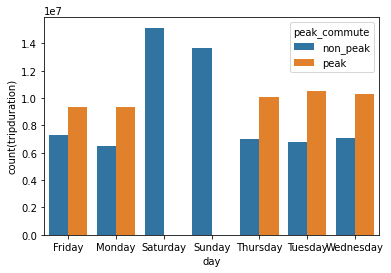

In [66]:
sb.barplot(data = sb_df, x = 'day', y = 'count(tripduration)', hue = 'peak_commute')

**Trip durations:**

<AxesSubplot:xlabel='day', ylabel='(avg(tripduration) / 60)'>

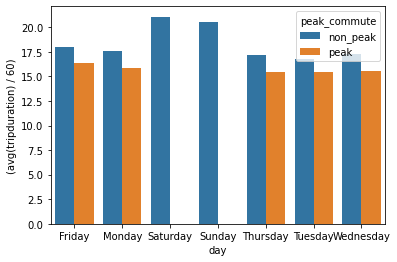

In [67]:
sb.barplot(data = sb_df, x = 'day', y = '(avg(tripduration) / 60)', hue = 'peak_commute')

In [68]:
sb_df = bike_gt2017.groupBy('weather_main', 'peak_commute')\
.agg(F.mean('tripduration')/60, F.count('tripduration'))\
.sort(['weather_main', 'peak_commute'])

In [69]:
sb_df = sb_df.toPandas()

In [70]:
sb_df

,weather_main,peak_commute,(avg(tripduration) / 60),count(tripduration)
0,Clear,non_peak,19.604422,30106457
1,Clear,peak,15.940208,21424593
2,Clouds,non_peak,18.846084,19475530
3,Clouds,peak,15.906759,17570434
4,Drizzle,non_peak,10.576008,339
5,Fog,non_peak,14.997894,107269
6,Fog,peak,13.600072,70497
7,Haze,non_peak,19.663033,943980
8,Haze,peak,17.111334,578911
9,Mist,non_peak,16.569241,4450911


<AxesSubplot:xlabel='peak_commute', ylabel='count(tripduration)'>

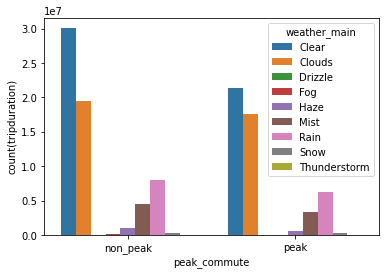

In [71]:
sb.barplot(data = sb_df, x = 'peak_commute', y = 'count(tripduration)', hue = 'weather_main')

**Huge differences in trip numbers between weather types.**

<AxesSubplot:xlabel='weather_main', ylabel='count(tripduration)'>

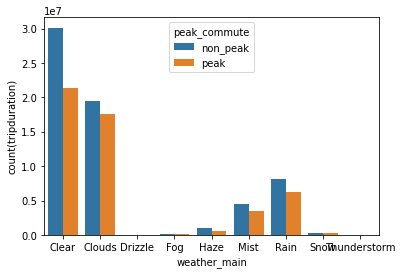

In [72]:
sb.barplot(data = sb_df, x = 'weather_main', y = 'count(tripduration)', hue = 'peak_commute')

<AxesSubplot:xlabel='weather_main', ylabel='(avg(tripduration) / 60)'>

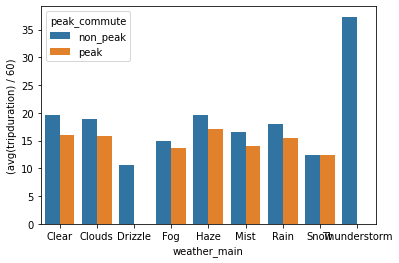

In [73]:
sb.barplot(data = sb_df, x = 'weather_main', y = '(avg(tripduration) / 60)', hue = 'peak_commute')

In [74]:
# create general precipication columns rather than rain and snow split
bike_gt2017 = bike_gt2017.withColumn('3h_precip', bike_gt2017.rain_3h + bike_gt2017.snow_3h)\
.withColumn('1h_precip', bike_gt2017.rain_1h + bike_gt2017.snow_1h)

*See missing data*

In [75]:
bike_gt2017.select([F.count(when(col(c).isNull(), c)).alias(c) for c in bike_gt2017.columns]).show()

+----+----+------------+---------+--------------+----------------+--------------------+---------------------+------------+--------------+------------------+-------------------+-------+--------+---------+-------+----+----------+--------+--------+--------+--------+----------+-------+-------+-------+-------+----------+------------+---+---+-----+--------+------------+----+---------+---------+
|date|hour|tripduration|starttime|startStationId|startStationName|startStationLatitude|startStationLongitude|endStationId|endStationName|endStationLatitude|endStationLongitude| bikeid|usertype|birthyear| gender|temp|feels_like|temp_min|temp_max|pressure|humidity|wind_speed|rain_1h|rain_3h|snow_1h|snow_3h|clouds_all|weather_main|dow|day|month|time_bin|peak_commute|year|3h_precip|1h_precip|
+----+----+------------+---------+--------------+----------------+--------------------+---------------------+------------+--------------+------------------+-------------------+-------+--------+---------+-------+----+

In [76]:
bike_gt2017.count()

113163477

In [77]:
bike_gt2017.show()

+----------+----+------------+--------------------+--------------+------------------+--------------------+---------------------+------------+--------------------+------------------+-------------------+-------+----------+---------+------+------+----------+--------+--------+--------+--------+----------+-------+-------+-------+-------+----------+------------+---+---------+-----+--------+------------+----+---------+---------+
|      date|hour|tripduration|           starttime|startStationId|  startStationName|startStationLatitude|startStationLongitude|endStationId|      endStationName|endStationLatitude|endStationLongitude| bikeid|  usertype|birthyear|gender|  temp|feels_like|temp_min|temp_max|pressure|humidity|wind_speed|rain_1h|rain_3h|snow_1h|snow_3h|clouds_all|weather_main|dow|      day|month|time_bin|peak_commute|year|3h_precip|1h_precip|
+----------+----+------------+--------------------+--------------+------------------+--------------------+---------------------+------------+-------

In [78]:
#bike_gt2017.select(bike_gt2017.weather_main).distinct().show()

In [79]:
#bike_gt2017.select(bike_gt2017.startStationId).distinct().show()

### We do not care about exact type of precipitation event, particularly since trip characteristics between the types are so imbalanced. Map to `precip` v. `no_precip`.

In [80]:
precip_map = {'Thunderstorm':'precip', 'Drizzle':'precip', 
 'Fog':'no_precip', 'Clear':'no_precip', 
 'Mist':'precip', 'Clouds':'no_precip', 'Rain':'precip', 
 'Snow':'precip', 'Haze':'no_precip'}

In [81]:
bike_gt2017 = bike_gt2017.withColumn('precip', translate(precip_map)('weather_main'))

In [82]:
bike_gt2017.show(5)

+----------+----+------------+--------------------+--------------+------------------+--------------------+---------------------+------------+--------------------+------------------+-------------------+-------+----------+---------+------+------+----------+--------+--------+--------+--------+----------+-------+-------+-------+-------+----------+------------+---+---------+-----+--------+------------+----+---------+---------+---------+
|      date|hour|tripduration|           starttime|startStationId|  startStationName|startStationLatitude|startStationLongitude|endStationId|      endStationName|endStationLatitude|endStationLongitude| bikeid|  usertype|birthyear|gender|  temp|feels_like|temp_min|temp_max|pressure|humidity|wind_speed|rain_1h|rain_3h|snow_1h|snow_3h|clouds_all|weather_main|dow|      day|month|time_bin|peak_commute|year|3h_precip|1h_precip|   precip|
+----------+----+------------+--------------------+--------------+------------------+--------------------+---------------------+

In [83]:
bike_gt2017 = bike_gt2017.withColumn('3h_precip', bike_gt2017.rain_3h + bike_gt2017.snow_3h)\
.withColumn('1h_precip', bike_gt2017.rain_1h + bike_gt2017.snow_1h)

<AxesSubplot:xlabel='precip', ylabel='(avg(tripduration) / 60)'>

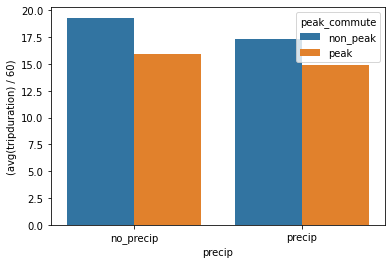

In [87]:
sb.barplot(data = sb_df, x = 'precip', y = '(avg(tripduration) / 60)', hue = 'peak_commute')

In [84]:
bike_gt2017.show(5)

+----------+----+------------+--------------------+--------------+------------------+--------------------+---------------------+------------+--------------------+------------------+-------------------+-------+----------+---------+------+------+----------+--------+--------+--------+--------+----------+-------+-------+-------+-------+----------+------------+---+---------+-----+--------+------------+----+---------+---------+---------+
|      date|hour|tripduration|           starttime|startStationId|  startStationName|startStationLatitude|startStationLongitude|endStationId|      endStationName|endStationLatitude|endStationLongitude| bikeid|  usertype|birthyear|gender|  temp|feels_like|temp_min|temp_max|pressure|humidity|wind_speed|rain_1h|rain_3h|snow_1h|snow_3h|clouds_all|weather_main|dow|      day|month|time_bin|peak_commute|year|3h_precip|1h_precip|   precip|
+----------+----+------------+--------------------+--------------+------------------+--------------------+---------------------+

### Get unique stations and their lats and longs
- We need to use these to help map and join to other data

In [99]:
stat_df = bike_gt2017.select('startStationId', 'startStationName', 'startStationLatitude', 'startStationLongitude')\
.distinct()

In [102]:
stat_df = stat_df.toPandas()

In [105]:
stat_df.to_csv('\stations.csv')

### Write joined weather and Citi Bike data to parquet files

In [88]:
bike_gt2017.write.parquet("/project/ds5559/Summer2021_TeamBike/gt2017_bikeweather.parquet") 